In [1]:
import torch as torch
import pandas as pd
import numpy as np
from sklearn import preprocessing
from neuralnetwork import *
from reading import *
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

torch.cuda.set_device(1)
device = ("cuda:1" if torch.cuda.is_available() else"cpu")
print(f"Using {device} from {torch.cuda.get_device_name()}")

Using cuda:1 from NVIDIA GeForce RTX 2080 Ti


In [2]:
all_data = np.load("serialized_object/all_data_cancer_type_MA.npy",allow_pickle=True)
print("All done\nName of the variable containing all data : all_data")
print("_________________________")
y = all_data[:,0]
all_data = np.delete(all_data,0,1)
dataset = DataSetMicroArray(all_data[:,1:],all_data[:,0],device)
idx = generation_indexes(dataset)
base_bs=256 
margin=0.5
bs = round(len(idx[0])/(len(idx[0]) // base_bs + margin ))
dataloaders = get_dalaloaders(dataset,idx,[bs,bs,bs])
input_dim = dataloaders[0].dataset.inputs.shape[1]
output_dim = 1
net1 = Network(input_dim,output_dim).to(device)
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net1.parameters(), lr=0.0001)

All done
Name of the variable containing all data : all_data
_________________________
27887 elements in the dataset
19520 elements in trainset
4183 elements in valset
4184 elements in testset


In [3]:
true_Y = np.take(y,idx[0])

In [4]:
len(true_Y)

19520

In [5]:
X_fc1=[]
X_fc2=[]
X_fc3=[]

# Entrainement Cell ------> Prediction Patient

In [6]:
tqdm(mean_network(100,1, net1, dataloaders,dataloaders))

0/1 réseau
Pre-training net done in : 80.04027358600001econds ||  
 Val Loss=0.1696 | Val Acc=0.9594   ||   Test Loss=0.1628 | Test Acc=0.9615


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
net1.fc1.register_forward_hook(forward_hook(X_fc1))
net1.fc2.register_forward_hook(forward_hook(X_fc2))
net1.fc3.register_forward_hook(forward_hook(X_fc3))

In [8]:
_ = evaluate_epoch( net1, dataloaders[0],loss_function)

In [9]:
X_fc1, Y_cell_fc1 = construct_list_hook(X_fc1, dataloaders)
X_fc2, Y_cell_fc2 = construct_list_hook(X_fc2, dataloaders)
X_fc3, Y_cell_fc3 = construct_list_hook(X_fc3, dataloaders)

In [10]:
pca2D = PCA(n_components=2)

Xt_fc1 = pca2D.fit_transform(X_fc1)
Xt_fc2 = pca2D.fit_transform(X_fc2)
Xt_fc3 = pca2D.fit_transform(X_fc3)


# PCA

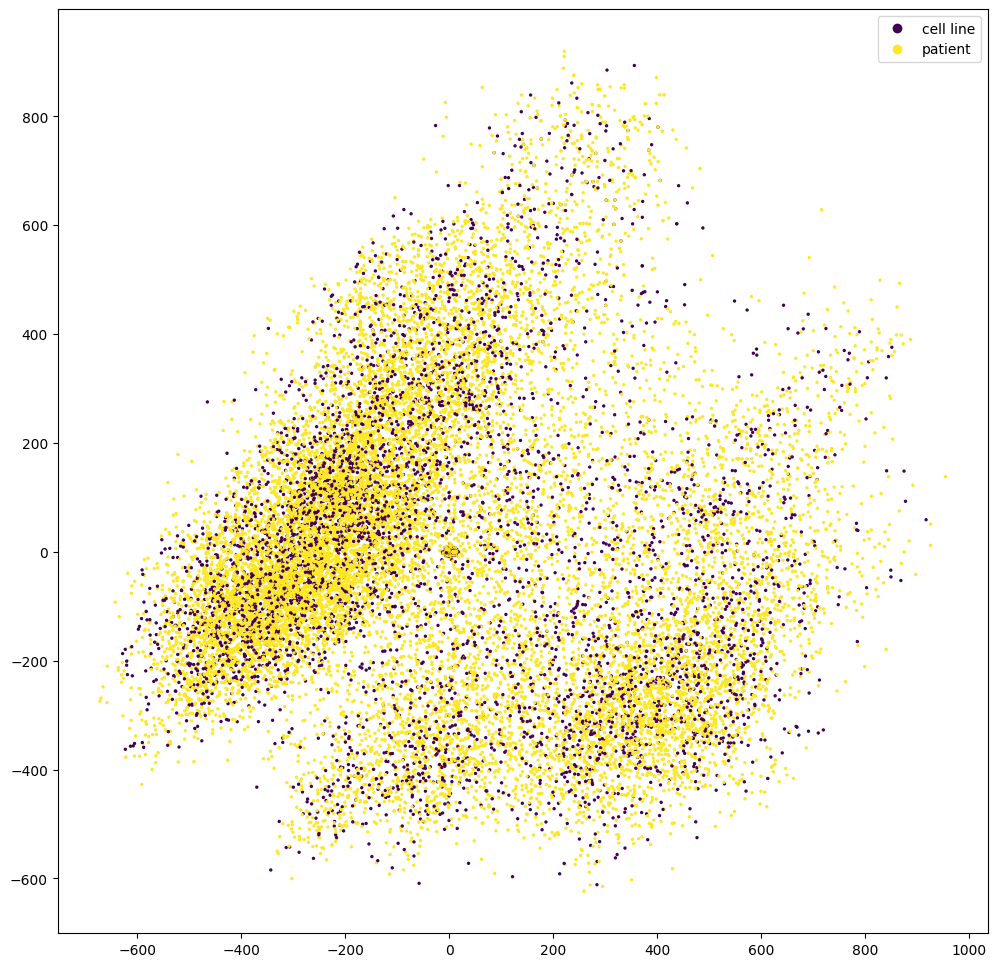

In [13]:
fig4 = plt.figure(figsize=(12,12))
scatter = plt.scatter(Xt_fc1[:,0],Xt_fc1[:,1], s=2,c=true_Y)
plt.legend(handles = scatter.legend_elements()[0], labels=['cell line','patient'])

scatter = plt.scatter(Xt_fc2[:,0],Xt_fc2[:,1], s=2,c=true_Y,label='Cell')
plt.legend(handles = scatter.legend_elements()[0], labels=['cell line','patient'])
scatter = plt.scatter(Xt_fc3[:,0],Xt_fc3[:,1], s=2,c=true_Y,label='Cell')
plt.legend(handles = scatter.legend_elements()[0], labels=['cell line','patient'])
for ax in fig4.get_axes():
    ax.label_outer()
fig4.savefig("MLP_PCA_Cell_to_Patient.png")

# UMAP

In [ ]:
import umap.plot
import umap

In [ ]:
%%time
mapper_fc1 = umap.UMAP(n_neighbors=15, min_dist=0.1,n_components=2).fit(X_fc1)
mapper_fc2 = umap.UMAP(n_neighbors=15, min_dist=0.1,n_components=2).fit(X_fc2)
mapper_fc3 = umap.UMAP(n_neighbors=15, min_dist=0.1,n_components=2).fit(X_fc3)

In [ ]:
umap.plot.points(mapper_fc1, labels=distribution, color_key_cmap='Paired')

In [ ]:
umap.plot.points(mapper_fc2, labels=distribution, color_key_cmap='Paired')

In [ ]:
umap.plot.points(mapper_fc3, labels=distribution, color_key_cmap='Paired')

# T-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
Xe_all_fc1 = TSNE().fit_transform(X_fc1)
Xe_all_fc2 = TSNE().fit_transform(X_fc2)
Xe_all_fc3 = TSNE().fit_transform(X_fc3)

In [ ]:
fig5 = plt.figure(figsize=(12,12))
gs = fig5.add_gridspec(2,2, hspace=0,wspace=0)
(ax1, ax2),(ax3,ax4) = gs.subplots(sharex='col', sharey='row')
ax1.scatter(Xe_all_fc1[:,0],Xe_all_fc1[:,1], s=2,c=distribution,label='Cell')
ax1.legend(loc='upper right')
ax2.scatter(Xe_all_fc2[:,0],Xe_all_fc2[:,1], s=2,c=distribution,label='Cell')
ax2.legend(loc='upper right')
ax3.scatter(Xe_all_fc3[:,0],Xe_all_fc3[:,1], s=2,c=distribution,label='Cell')
ax3.legend(loc='upper right')
for ax in fig5.get_axes():
    ax.label_outer()
fig5.savefig("MLP_TSNE_Cell_to_Patient.png")